Hi everyone! In this notebook we will learn how to train a model with eager mode of Tensorflow 2. For teaching objectives, we just focus on implementing the training phase with eager mode. A more comprehensive training procedure is given in KerasTraining.ipynb.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
print(tf.__version__)

2.3.0


In [2]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [3]:
def show_images(dataset, class_names, predicts=None):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.8, wspace=0.4)
    for i, (image, label) in enumerate(dataset):
        if i>= 9: 
            break
        if image.shape[-1] == 1:
            revised_image = np.squeeze(image)
        else:
            revised_image = image
        axes.flat[i].imshow(revised_image)
        # Name of the true class.
        label_name = class_names[label]
        
        # Show true and predicted classes.
        if predicts is None:
            axes.flat[i].set_xlabel("True : {0}".format(label_name))
        else:
            predict_name = class_names[predicts[i]]
            axes.flat[i].set_xlabel("True: {0}\nPred: {1}".format(label_name, predict_name))
        # Remove ticks from the plot.
        axes.flat[i].set_xticks([])
        axes.flat[i].set_yticks([])
    while(i < 8):
        i += 1
        axes.flat[i].axis('off')
    plt.show()

Preparing Data

(60000, 28, 28)   (60000,)
(10000, 28, 28)   (10000,)


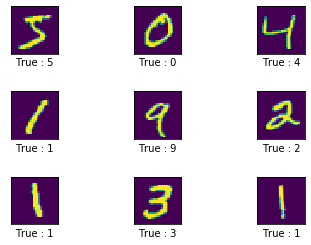

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, ' ', y_train.shape)
print(x_test.shape, ' ', y_test.shape)
x_train = x_train.astype('float32').reshape((-1,28,28,1))
x_test = x_test.astype('float32').reshape((-1,28,28,1))
x_train /= 255.0
x_test /= 255.0
trainDataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
testDataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
show_images(trainDataset, class_names)

Preparing a simple Model.

In [5]:
cnnModel = keras.Sequential()
cnnModel.add(layers.Conv2D(input_shape=[28,28,1],filters = 32, kernel_size = 3, strides = 1,
                       activation = 'relu'))
cnnModel.add(layers.Conv2D(filters = 32, kernel_size = 3, strides = 1,
                       activation = 'relu'))
cnnModel.add(layers.MaxPool2D(pool_size = 2, strides = 2))
cnnModel.add(layers.Conv2D(filters = 64, kernel_size = 3, strides = 1,
                       activation = 'relu'))
cnnModel.add(layers.Conv2D(filters = 64, kernel_size = 3, strides = 1,
                       activation = 'relu'))
cnnModel.add(layers.MaxPool2D(pool_size = 2, strides = 2))
cnnModel.add(layers.Flatten())
cnnModel.add(layers.Dense(units = 512, activation = 'relu'))
cnnModel.add(layers.Dense(units = 10, activation = 'softmax'))
cnnModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

Necessary components in training procedure: <b>Optimizer</b>, <b>loss</b> and <b>metrics</b>.

In [6]:
optimizer = tf.keras.optimizers.RMSprop()

compute_loss = tf.keras.losses.SparseCategoricalCrossentropy()

compute_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

Automatic differentiation is useful for implementing machine learning algorithms such as backpropagation for training neural networks. During eager execution, use tf.GradientTape to trace operations for computing gradients later.

All forward-pass operations get recorded to a "tape". To compute the gradient, play the tape backwards and then discard. So a particular tf.GradientTape can only compute gradient once; subsequent calls throw a runtime error.

In [7]:
@tf.function
def train_one_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss = compute_loss(y, logits)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    compute_accuracy(y, logits)
    return loss

tf.function annotation will construct a graph by packing operations in the function, which may reduce the running time. However, more time is needed for initializing the graph.

In [8]:
subTrainDataset = trainDataset.shuffle(buffer_size=1024).batch(64)
subTestDataset = testDataset.batch(64)

In [9]:
def train(model, optimizer, trainDataset, epochs):
    for epoch in range(epochs):
        print("epoch: ", epoch)
        start_time = time.time()
        step = 0
        compute_accuracy.reset_states()
        for x,y in trainDataset:
            step += 1
            loss = train_one_step(model, optimizer, x, y)
            if step % 50 == 0:
                tf.print("Loss: ", loss, "Accuracy on training data:", compute_accuracy.result())
        compute_accuracy.reset_states()
        
        for x, y in subTestDataset:
            logits = model(x, training=False)
            compute_accuracy(y, logits)
        test_acc = compute_accuracy.result()
        print("Accuracy on testing data: %.4f" % (float(test_acc),))
        print("Time taken: %.2fs" % (time.time() - start_time))

In [10]:
train(cnnModel, optimizer, subTrainDataset, 2)

epoch:  0
Loss:  0.112843394 Accuracy on training data: 0.759375
Loss:  0.259834796 Accuracy on training data: 0.85125
Loss:  0.0774686486 Accuracy on training data: 0.883229196
Loss:  0.030379951 Accuracy on training data: 0.903906226
Loss:  0.138212144 Accuracy on training data: 0.91625
Loss:  0.0586102158 Accuracy on training data: 0.925052106
Loss:  0.154582456 Accuracy on training data: 0.93267858
Loss:  0.14906846 Accuracy on training data: 0.938320339
Loss:  0.0108152125 Accuracy on training data: 0.942534745
Loss:  0.0205701329 Accuracy on training data: 0.946062505
Loss:  0.0199248902 Accuracy on training data: 0.949289799
Loss:  0.0153310709 Accuracy on training data: 0.952005208
Loss:  0.00597275514 Accuracy on training data: 0.954230785
Loss:  0.0119968634 Accuracy on training data: 0.95622766
Loss:  0.0254145954 Accuracy on training data: 0.957708359
Loss:  0.00717533 Accuracy on training data: 0.959609389
Loss:  0.0196807701 Accuracy on training data: 0.960992634
Loss:  0

In [11]:
predict_result = tf.argmax(cnnModel.predict(trainDataset.take(9).batch(9)),axis=1)

In [12]:
predict_result.numpy()

array([5, 0, 4, 1, 9, 2, 1, 3, 1], dtype=int64)

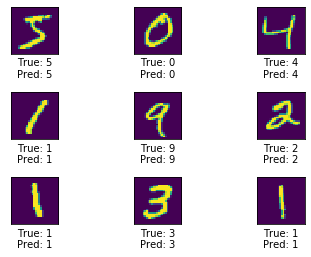

In [13]:
show_images(trainDataset, class_names, predict_result)